## A short analysis of Drip - a Patreon clone :p

<b>But Why?</b><br>
As I am interviewing for a Data Scientist position at Patreon, it seemed:
- fun to prepare by practicing my Python and Analysis skills,
- while maybe providing a some useful insights.

<b>And How?</b> <br>
- First, by opening up the Chrome Console on Drip and looking at the relevant API calls.
- Then figuring out that the API is in GraphQL which I had to get familiar with, so I can tweak the requests and exactly the data I want.
- And finally, by visualizing the data.

For context, you can read the [Blog Post](https://www.kickstarter.com/blog/introducing-the-new-drip) from Nov 15 2017, announcing the re-launch by Kickstarter, since the 2016 acquisition.

Now, let's jump in.

In [43]:
import requests
import json
from datetime import datetime
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# we are going to show images
from IPython.display import Image
from IPython.core.display import HTML 


# default figsize for the whole notebook
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
def call_api(cursor):
    """Makes a single API request to dr.ip GraphQL API to get creators"""

    print("calling API with cursor: %s" % cursor)
    url = "https://www.kickstarter.com/graph"

    # Reversed engineered this request by inspecting requests from https://d.rip/discover
    # Note: I had to add some fields in the request
    variables_str = "{\"perPage\":%(perPage)s,\"cursor\":\"%(cursor)s\"}}" % { 'perPage': 100, 'cursor': cursor }
    payload = "{\"query\":\"query($perPage:  Int!,  $cursor:  String)  {  drops(first:  $perPage,  after:  $cursor,  filter:  LIVE)  {  edges  {  cursor  node  {  id  blurb  foundingAt  activeAt  foundingDays  foundingMembersCount  enableEarningsDisplay  description  pledgesTotalAmount  {  amount  currency  }  pledgesCount  headerImage  {  url(width:650)  }  headerVideo  {  id  poster  }  phase  slug  category  {  name  slug  }  creator  {  name  imageUrl(width:60)  }  publishedPostsCount  }  }  pageInfo  {  hasNextPage  endCursor  }  }  }  \",\"variables\": %(variables_str)s" % { 'variables_str': variables_str }

    headers = {
        'authorization': "token null",
        'origin': "https://d.rip",
        'x-devtools-emulate-network-conditions-client-id': "2387BBC7A16C6222B9D3B0DA5F9F6688",
        'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36",
        'content-type': "application/json",
        'accept': "*/*",
        'referer': "https://d.rip/discover",
        'accept-encoding': "gzip, deflate, br",
        'accept-language': "en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7",
        'cache-control': "no-cache",
        }

    response = requests.request("POST", url, headers=headers, data=payload)
    data = json.loads(response.text)

    return data

In [3]:
print_creator = True

def creator_edge_to_row(edge):
    """Converts Creator Edge from GraphQL to a 1-dimensional row"""

    row = edge['node']

    # useful to visualize the whole response, we only print one 
    global print_creator

    if print_creator:
        print(json.dumps(edge['node'], indent=4))
        print_creator = False

    new_row = dict((key, row[key]) for key in ('id', 'blurb', 'foundingAt', 'activeAt', 'foundingDays', 'foundingMembersCount', 'enableEarningsDisplay', 'pledgesCount', 'phase', 'slug', 'publishedPostsCount'))
    
    if row['category']:
        new_row['categorySlug'] = row['category']['slug']
    else:
        new_row['categorySlug'] = np.nan
        
    if row['pledgesTotalAmount']:
        new_row['pledgesTotalAmount'] =  float(row['pledgesTotalAmount']['amount'])
        new_row['pledgesTotalCurrency'] =  row['pledgesTotalAmount']['currency']
    else:
        new_row['pledgesTotalAmount'] = 0
        new_row['pledgesTotalCurrency'] = np.nan

    return new_row

In [4]:
def get_creators(cursor=None):
    """Makes a single API request to dr.ip GraphQL API to get creators. Returns Creator Edges and pagination cursor"""

    data = call_api(cursor)
    creator_edges = data['data']['drops']['edges']
    end_cursor = data['data']['drops']['pageInfo']['endCursor']
    return (creator_edges, end_cursor)

In [5]:
def load_all_drip_creators():
    """Calls the dr.ip API until all creators are loaded. Returns a DataFrame of all creators"""
    creator_rows = []
    cursor = ''

    while cursor != None:
        creator_edges, cursor = get_creators(cursor)
        print("{dt}: returned {creators_count} creators, and cursor: {cursor}".format(dt=datetime.now(), creators_count=len(creator_edges), cursor=cursor))

        for edge in creator_edges:
            creator_rows.append(creator_edge_to_row(edge))

        # sleep for a time between 1s and 3s
        time.sleep(1 + random.random()*2)

    print("Total creators loaded: ", len(creator_rows))
    
    return pd.DataFrame.from_records(creator_rows)

In [6]:
df = load_all_drip_creators()

calling API with cursor: 
2018-05-17 19:45:20.975345: returned 50 creators, and cursor: NTA=
{
    "id": "RHJvcC0yMjY=",
    "blurb": "Got a Girl Crush aims to disrupt the broken narrative of most women's publications and tell stories of all ages, races, and backgrounds of women all over the world. Learn more at gotagirlcrush.com",
    "foundingAt": 1522081683,
    "activeAt": 1524673683,
    "foundingDays": 30,
    "foundingMembersCount": 27,
    "enableEarningsDisplay": true,
    "description": "<p>Much like your favorite podcast and public radio station, we survive on the support of our readers who enjoy what we do.</p>\n<p><em>For less than the cost of your daily latt\u00e9 habit, you can chip in once a month and help sustain </em><a href=\"http://www.gotagirlcrush.com/\" target=\"_blank\" rel=\"noopener\"><em>Got a Girl Crush</em></a><em>!</em></p>\n<p><strong>We believe that print is not dead</strong> and that there is value to having a tangible medium to read, digest, and share-

### The very first insight...

There are only 92 creators on the platform! One reason is that it's very new, another one is in the FAQ:

In [7]:
Image(url= "https://www.dropbox.com/s/p1bn6i5baju8b6b/Screenshot%202018-05-17%2018.22.34.png?dl=1")

### Let's clean up the Data Frame

In [8]:
df.head()

,activeAt,blurb,categorySlug,enableEarningsDisplay,foundingAt,foundingDays,foundingMembersCount,id,phase,pledgesCount,pledgesTotalAmount,pledgesTotalCurrency,publishedPostsCount,slug
0,1524673683,Got a Girl Crush aims to disrupt the broken na...,publishing,True,1522081683,30,27,RHJvcC0yMjY=,ACTIVE,27,165.0,USD,9,girl-crush
1,1511964921,"I try to make objects, spaces (both physical a...",art,True,1510754503,14,24,RHJvcC0xMjg=,ACTIVE,22,101.0,USD,17,azikiwe-mohammed
2,1525238041,Broccoli and Ice Cream is a fun new podcast by...,podcasts-and-radio,True,1522646041,30,17,RHJvcC0yMzA=,ACTIVE,17,71.0,USD,13,broccoliandicecream
3,1513088128,"Every day I draw with a pen, a marker, or musi...",art,False,1510754503,27,26,RHJvcC03Nw==,ACTIVE,23,0.0,NaN,25,shantell-martin
4,1513347324,Richard Herring’s Podcasts - Help us to make e...,film-and-video,True,1510754504,30,1065,RHJvcC0xNjE=,ACTIVE,1113,3453.0,GBP,14,richard-herring


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
activeAt                 92 non-null int64
blurb                    92 non-null object
categorySlug             90 non-null object
enableEarningsDisplay    92 non-null bool
foundingAt               92 non-null int64
foundingDays             92 non-null int64
foundingMembersCount     92 non-null int64
id                       92 non-null object
phase                    92 non-null object
pledgesCount             92 non-null int64
pledgesTotalAmount       92 non-null float64
pledgesTotalCurrency     71 non-null object
publishedPostsCount      92 non-null int64
slug                     92 non-null object
dtypes: bool(1), float64(1), int64(6), object(6)
memory usage: 9.5+ KB


#### Let's fix type on datetime fields and index by unique id

In [10]:
df['activeAt'] = pd.to_datetime(df['activeAt'], unit='s')
df['foundingAt'] = pd.to_datetime(df['foundingAt'], unit='s')
df = df.set_index('id')
df.head()

,activeAt,blurb,categorySlug,enableEarningsDisplay,foundingAt,foundingDays,foundingMembersCount,phase,pledgesCount,pledgesTotalAmount,pledgesTotalCurrency,publishedPostsCount,slug
id,,,,,,,,,,,,,
RHJvcC0yMjY=,2018-04-25 16:28:03,Got a Girl Crush aims to disrupt the broken na...,publishing,True,2018-03-26 16:28:03,30,27,ACTIVE,27,165.0,USD,9,girl-crush
RHJvcC0xMjg=,2017-11-29 14:15:21,"I try to make objects, spaces (both physical a...",art,True,2017-11-15 14:01:43,14,24,ACTIVE,22,101.0,USD,17,azikiwe-mohammed
RHJvcC0yMzA=,2018-05-02 05:14:01,Broccoli and Ice Cream is a fun new podcast by...,podcasts-and-radio,True,2018-04-02 05:14:01,30,17,ACTIVE,17,71.0,USD,13,broccoliandicecream
RHJvcC03Nw==,2017-12-12 14:15:28,"Every day I draw with a pen, a marker, or musi...",art,False,2017-11-15 14:01:43,27,26,ACTIVE,23,0.0,NaN,25,shantell-martin
RHJvcC0xNjE=,2017-12-15 14:15:24,Richard Herring’s Podcasts - Help us to make e...,film-and-video,True,2017-11-15 14:01:44,30,1065,ACTIVE,1113,3453.0,GBP,14,richard-herring


#### Reorder columns to highlight most interesting

In [11]:
df = df[['slug', 'categorySlug', 'foundingMembersCount', 'foundingDays', 'pledgesCount','pledgesTotalAmount',
    'pledgesTotalCurrency', 'publishedPostsCount','activeAt', 'blurb', 'enableEarningsDisplay','foundingAt', 'phase'
   ]]

In [12]:
# df.to_pickle('drip_2018_05_17')

#### Let's make sure we understand the data set. This is the creator page for 'girl-crush' 

In [13]:
Image(url= "https://photos-2.dropbox.com/t/2/AAAY6UcqmzNQbgPANdBmEUItjkxTdHp69VnbtzWocu4zMw/12/712284/png/32x32/1/_/1/2/Screenshot%202018-05-17%2016.50.33.png/EOCPWxi6j8DZBCACKAI/FVc2txauLBP2sEh0_gq1YGxAhXX3FBeBycAGDXnIpCU?preserve_transparency=1&size=32x32&size_mode=5")

In [14]:
df[df['slug']=='girl-crush'].iloc[0].to_frame()

,RHJvcC0yMjY=
slug,girl-crush
categorySlug,publishing
foundingMembersCount,27
foundingDays,30
pledgesCount,27
pledgesTotalAmount,165
pledgesTotalCurrency,USD
publishedPostsCount,9
activeAt,2018-04-25 16:28:03
blurb,Got a Girl Crush aims to disrupt the broken na...


It seems that:
- <b>foundingMembersCount</b> is the number of subscribers (27 in this case)
- <b>pledgesTotalAmount</b> is the monthly income ($165 here)

but <b>foundingDays</b> is unclear.

In [15]:
df['foundingDays'].value_counts()

30    49
7     13
21     7
15     7
14     5
20     4
28     1
27     1
25     1
18     1
17     1
16     1
9      1
Name: foundingDays, dtype: int64

It looks like a frequency, maybe it's the frequency of pledges. let's pull up an example.

In [16]:
df[df['foundingDays'] == 7].iloc[0].to_frame()

,RHJvcC01Mg==
slug,femfreq
categorySlug,podcasts-and-radio
foundingMembersCount,149
foundingDays,7
pledgesCount,243
pledgesTotalAmount,2310
pledgesTotalCurrency,USD
publishedPostsCount,77
activeAt,2017-11-22 14:15:22
blurb,A new podcast 🎤 discussing feminism & pop cult...


In [17]:
Image(url= "https://www.dropbox.com/s/xulrswio8w4x6pn/Screenshot%202018-05-17%2016.58.43.png?dl=1")

Even with a <b>foundingDays</b> value of 7, the income and subscriptions values are all monthly.
Let's ignore <b>foundingDays</b> for now.

### What is the difference between foundingMembers and pledgesCount?

The blog post mentioned in the intro describes the concept of founding members:
> Every Drip begins with a founding membership period to help creators build momentum. The founding membership period is a way for creators to entice their fans, friends, and new audiences to jump in and build up their base of support. (This is not all-or-nothing like Kickstarter, but it does build on our experience that a strong call to action is essential.) Creators can offer their founding members special rewards or status for jumping in early. We know creators will be really creative with how they think of founding memberships, and we’re excited to see how it’s put to use.

In [18]:
# Let's compute the difference between founding Members and Pledges, and bin the results in 3 categories

df['pledgeDiff'] = pd.cut(df['pledgesCount'] - df['foundingMembersCount'],
                   bins=[ -100,  -0.1, 0, 100 ],
                   labels=('fewer', 'equal', 'more'))

Text(0.5,1,'Number of pledges compared Founding Members')

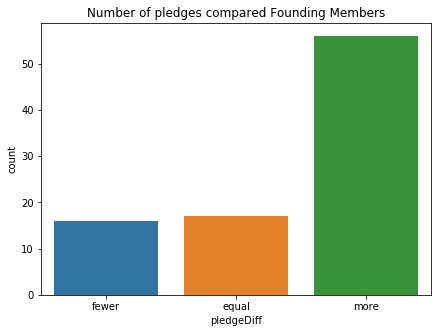

In [19]:
plt.figure(figsize=(7,5))
sns.countplot(x='pledgeDiff', data=df)
plt.title("Number of pledges compared Founding Members")

Most creators added more members since their founding period. <br>

## EDA

### Gross numbers

In [20]:
sums = df.select_dtypes('number').sum()
sums

foundingMembersCount     6126.0
foundingDays             2103.0
pledgesCount             7377.0
pledgesTotalAmount      21936.0
publishedPostsCount      1441.0
dtype: float64

#### Average Pledge

In [21]:
sums['pledgesTotalAmount'] / sums['pledgesCount']

2.9735664904432695

#### Average Pledges & Monthly earnings, Posts per creator

In [22]:
sums[[ 'pledgesTotalAmount', 'pledgesCount', 'publishedPostsCount'] ] / len(df)

pledgesTotalAmount     238.434783
pledgesCount            80.184783
publishedPostsCount     15.663043
dtype: float64

### Who's earning the most?

There are a few currencies represented but they're all of the same order of magnitude, so let's ignore exchange rates for now

In [23]:
df['pledgesTotalCurrency'].value_counts()

USD    65
EUR     4
GBP     2
Name: pledgesTotalCurrency, dtype: int64

#### Visualizing individual Creators

7 earners are earning around $1000+ / month

In [24]:
df.sort_values('pledgesTotalAmount', ascending=False).head(7)

,slug,categorySlug,foundingMembersCount,foundingDays,pledgesCount,pledgesTotalAmount,pledgesTotalCurrency,publishedPostsCount,activeAt,blurb,enableEarningsDisplay,foundingAt,phase,pledgeDiff
id,,,,,,,,,,,,,,
RHJvcC0xNjE=,richard-herring,film-and-video,1065,30,1113,3453.0,GBP,14,2017-12-15 14:15:24,Richard Herring’s Podcasts - Help us to make e...,True,2017-11-15 14:01:44,ACTIVE,more
RHJvcC04NA==,thornwillow,publishing,101,15,106,3442.0,USD,12,2017-11-30 14:15:22,"Support a small press, and receive a portfolio...",True,2017-11-15 14:01:43,ACTIVE,more
RHJvcC01Mg==,femfreq,podcasts-and-radio,149,7,243,2310.0,USD,77,2017-11-22 14:15:22,A new podcast 🎤 discussing feminism & pop cult...,True,2017-11-15 14:01:42,ACTIVE,more
RHJvcC0yMTQ=,electriclit,publishing,251,30,414,2049.0,USD,6,2018-04-06 02:15:22,Electric Lit is dedicated to making literature...,True,2018-03-07 03:07:29,ACTIVE,NaN
RHJvcC0xOTc=,bullypulpitgames,games,193,30,208,1339.0,USD,15,2018-03-29 13:15:23,"The award-winning publishers of Fiasco, The Wa...",True,2018-02-27 14:02:16,ACTIVE,more
RHJvcC0xOTQ=,maryrobinette,publishing,107,30,109,1265.0,USD,17,2018-03-31 22:15:20,"I'm a professional puppeteer, an audiobook nar...",True,2018-03-01 23:14:04,ACTIVE,more
RHJvcC02Mg==,ironspike,comics,196,15,199,995.0,USD,22,2017-11-30 14:15:22,"Welcome to the Iron Circus Sideshow! Art, comi...",True,2017-11-15 14:01:43,ACTIVE,more


#### Amount per Pledge by creator

In [25]:
df['AmountPerPledge'] = df['pledgesTotalAmount'] / df['pledgesCount']

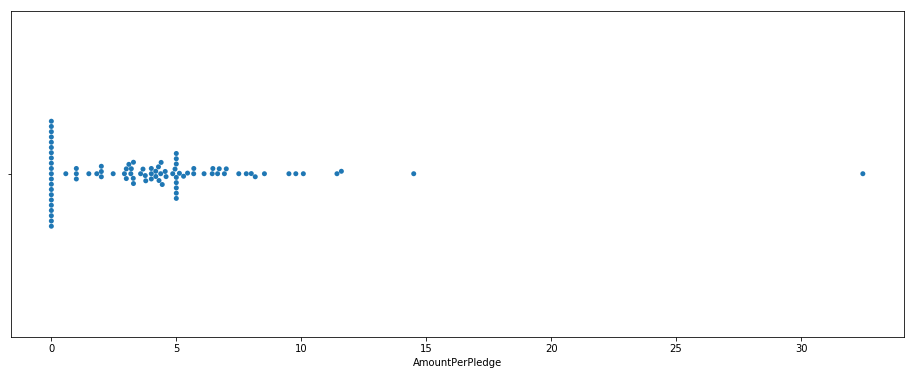

In [44]:
sns.swarmplot(df['AmountPerPledge'], orient='h')

#### When did these creators join?

In [27]:
timeseries = df[['foundingAt','slug']].set_index('foundingAt').sort_index()
timeseries.head()

,slug
foundingAt,
2017-11-15 14:01:42,well-read-black-girl
2017-11-15 14:01:42,willits
2017-11-15 14:01:42,femfreq
2017-11-15 14:01:42,debbie-millman
2017-11-15 14:01:43,peter


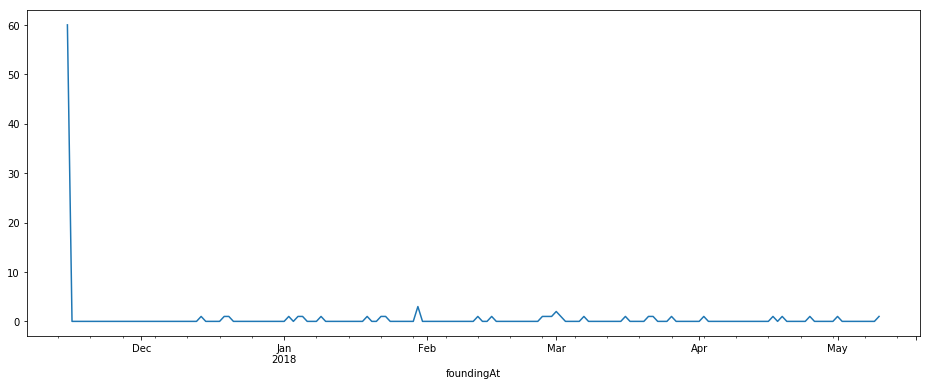

In [45]:
timeseries['slug'].resample('1D').count().plot()

60 of the 92 creators joined on November 15, this must have been the d.rip re-launch date since the Kickstarter acquisition. Since then they added creators slowly, on an invite-only basis.

### Diving into Categories

Text(0.5,1,'Each dot is a creator with their category and earnings.')

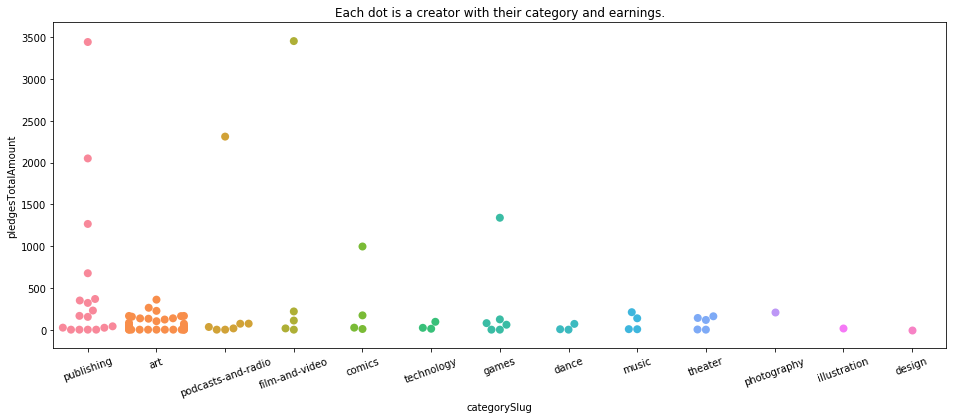

In [46]:
sns.swarmplot(x='categorySlug', y='pledgesTotalAmount', data=df, size=8)
plt.xticks(rotation=20)
plt.title('Each dot is a creator with their category and earnings.')

#### Which categories are most represented by Creators?

Text(0.5,1,'# Creators by Category')

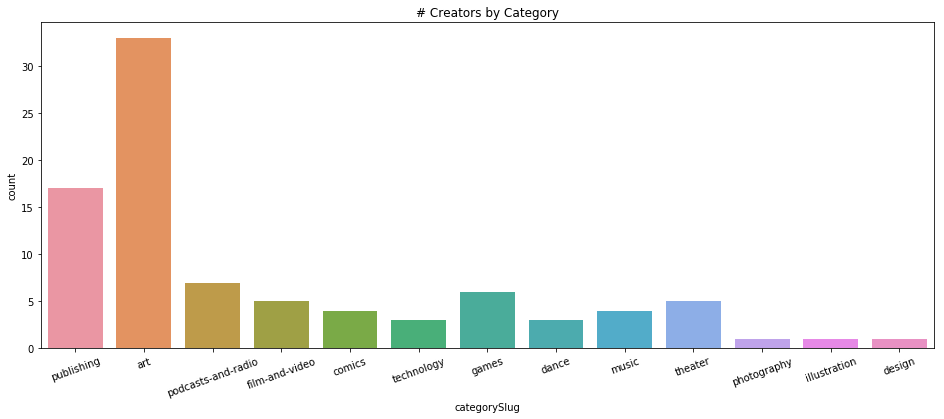

In [47]:
sns.countplot(x='categorySlug', data=df)
plt.xticks(rotation=20)
plt.title('# Creators by Category')

#### In which categories are creators earning the most?

Text(0.5,1,'Median Monthly Earnings by Creator in each Category')

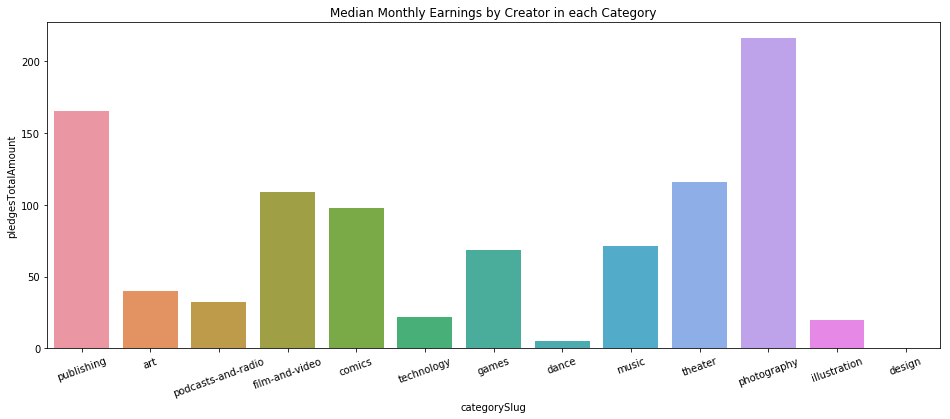

In [48]:
sns.barplot(x="categorySlug", y="pledgesTotalAmount", estimator=np.median, ci=None, data=df)
plt.xticks(rotation=20)
plt.title('Median Monthly Earnings by Creator in each Category')

#### Is the average Pledge Amount different by Category?

Text(0.5,1,'Average Pledge Amount in each Category')

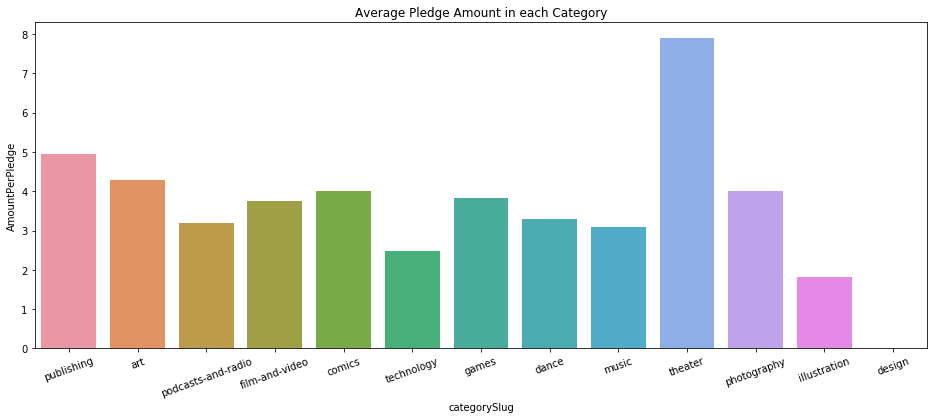

In [49]:
sns.barplot(x="categorySlug", y="AmountPerPledge", estimator=np.median, ci=None, data=df)
plt.xticks(rotation=20)
plt.title('Average Pledge Amount in each Category')

## How fast is d.rip growing?

The data above is from May 17th, but we also gathered a snapshot of data on May 15th.<br>
It's a short time period but still interesting how much growth there was over this 48 hours period.

In [33]:
df15 = pd.read_pickle('drip_2018_05_15')

In [34]:
# df = pd.read_pickle('drip_2018_05_17')

We merge May 15th data with May 17th data.

In [35]:
# Select only relevant columns
df15 = df15[ ['foundingMembersCount', 'pledgesCount', 'pledgesTotalAmount', 'publishedPostsCount' ] ]

#### How many creators were added?

In [36]:
len(set(df.index) - set(df15.index))

0

#### How many creators are gone?

In [37]:
len(set(df15.index) - set(df.index))

0

In [38]:
# Join the DataFrames
df = df.join(df15, rsuffix='_15')

In [39]:
# Compute differences
df['addedFoundingMembers'] = df['foundingMembersCount'] - df['foundingMembersCount_15']
df['addedPledgesCount'] = df['pledgesCount'] - df['pledgesCount_15']
df['addedPledgesTotalAmount'] = df['pledgesTotalAmount'] - df['pledgesTotalAmount_15']
df['addedPublishedPostsCount'] = df['publishedPostsCount'] - df['publishedPostsCount_15']

### Aggregates

In [40]:
df[['addedFoundingMembers', 'addedPledgesCount', 'addedPledgesTotalAmount', 'addedPublishedPostsCount']].sum()

addedFoundingMembers        -6.0
addedPledgesCount           33.0
addedPledgesTotalAmount     42.0
addedPublishedPostsCount    13.0
dtype: float64

In the last 48 hours Drip:
- lost 5 founding members (?). I'm not sure how, let's move on.
- added 34 Net pledges,
- added $42/month in Net pledge amounts
- published 13 Net posts by creators


Thanks for reading.